# Project Gutenberg Cooking Docs
---

# Setup

## Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob # quickly read directory systems (does not sort files same way on all OS!)
import re             # regular expressions
import nltk

In [2]:
%matplotlib inline
sns.set()

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /Users/Kobresia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Kobresia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Kobresia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/Kobresia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

## Set OHCO

In [4]:
#OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
#OHCO = ['book_id', 'sect_num', 'para_num', 'sent_num', 'token_num']
OHCO = ['book_id', 'vol_num', 'chap_num', 'recp_num', 'para_num', 'sent_num', 'token_num']

In [5]:
OHCO[:5]

['book_id', 'vol_num', 'chap_num', 'recp_num', 'para_num']

## Define Functions

### acquire_epubs()

In [6]:
def acquire_epubs(epub_list, OHCO=OHCO):
    
    my_lib = []
    my_doc = []
    author_full = ''

    for epub_file in epub_list:    
        
        # Get info for LIB table
        book_id = int(epub_file.split('_pg')[-1].split('.')[0].replace('b','1'))
        author_yr = epub_file.split('/')[-1].split('_')[0].replace('[0-9]','')
        author_last = author_yr[:-4]
        book_year = int(author_yr[-4:])

        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = str(book_id)
        
        # Get book title and put into LIB table
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[patterns[book_id]['start_text']].line_str, flags=re.IGNORECASE)
        temp = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        if temp.find(', by') > 0:
            author_full = temp.split(', by')[1].strip() 
        book_title = temp.split(', by')[0]
        if book_id == 19077:
            author_full = 'Janet McKenzie Hill'
        if book_id == 28681:
            author_full = 'William Kitchiner'
        
        print("BOOK ID:   ", book_id) 
        print("BOOK INFO: " + author_last+ ' ('+ str(book_year)+ ') - '+ book_title + '\n')
              
        # Remove crufts
        start = patterns[book_id]['start_line'] - 1
        stop  = patterns[book_id]['end_line'] + 1
        df = df.iloc[start:stop]        
        
        # -- Chunking ------------------------------------------------------------------------------------------------------------------------------
        
        # Chunk by Volume
        vol_lines = df.line_str.str.match(patterns[book_id]['volume'])
        if df[vol_lines].line_str.duplicated().any():            # remove duplicates
            ix = df[vol_lines].line_str.drop_duplicates().index  # ones to keep
            vol_lines[vol_lines] = False
            vol_lines[ix] = True
        vol_nums = [i+1 for i in range(df.loc[vol_lines].shape[0])]
        df.loc[vol_lines, 'vol_num'] = vol_nums
        if vol_nums == []:                                       # if no volumes, fill with zeros
            df['vol_num'] = 0
        df.vol_num = df.vol_num.ffill()
        #print("REGEX: ", patterns[book_id]['volume'], '\n')
        print('VOLUMES:  ', df[vol_lines].line_str.tolist())
        
        # Chunk by Chapter (remove empty chapters later)
        #print("REGEX: ", patterns[book_id]['chapter'])
        chap_lines = df.line_str.str.match(patterns[book_id]['chapter'])
        print('CHAPTERS: ', df[chap_lines].line_str.tolist(), '\n')
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        df.loc[chap_lines, 'chap_num'] = chap_nums
        if chap_nums == []:                                     # if no chapters, fill with zeros
            df['chap_num'] = 0
        df.chap_num = df.chap_num.ffill()

        # Chunk by Recipe
        #print("REGEX: ", patterns[book_id]['recipe'])
        recp_lines = df.line_str.str.match(patterns[book_id]['recipe'])
        #print('RECIPES: ', df[recp_lines].line_str.tolist(), '\n')
        recp_nums = [i+1 for i in range(df.loc[recp_lines].shape[0])]
        df.loc[recp_lines, 'recp_num'] = recp_nums
        if recp_nums == []:                                      # if no recipes, fill with zeros
            df['recp_num'] = 0
        df.recp_num = df.recp_num.ffill()
        
        # Recipe Correction when Intro Present (to prevent removal when Group below)
        if book_id == 19077:
            df.iloc[(df[df['line_str'].str.match('Our taste')].index.values.item()-336):(patterns[book_id]['start_recipe']-336-1), 4] = 0
        if book_id == 28681:
            df.iloc[(df[df['line_str'].str.match('The following receipts are not')].index.values.item()-478):(patterns[book_id]['start_recipe']-478-1), 4] = 0
            
        # -- End Chunking --------------------------------------------------------------------------------------------------------------------------

        # Clean up volumes
        df = df[~df.vol_num.isna()]  # Remove volume heading lines
        df = df.loc[~vol_lines]      # Remove everything before volume 1
        df['vol_num'] = df['vol_num'].astype('int')
        
        # Clean up chapters
        df = df[~df.chap_num.isna()] # Remove chapter heading lines
        df = df.loc[~chap_lines]     # Remove everything before chapter 1
        df['chap_num'] = df['chap_num'].astype('int')

        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:4]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')]         # Remove empty paragraphs
        para_lines = df['para_str'].str.match(patterns[book_id]['del_para'])
        #print(df[para_lines])
        df = df[~para_lines]                                 # Remove paragraphs matching conditions in patterns
        df.index.names = OHCO[1:5]                           # MAY NOT BE NECESSARY UNTIL THE END
                
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:5])

        # Register
        my_lib.append((book_id, author_last, author_full, book_year, book_title, epub_file))
        my_doc.append(df)  
        
        # END book_id
        print('------------------------------------------------------------------------------------------------------', '\n')
    
    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'author_last', 'author_full', 'book_year', 'book_title', 'book_file']).set_index('book_id')
    print("Done.")
    return library, docs   

### Patterns

In [7]:
roman = '[IVXLCM.]+'  # roman numerals
roman0 = '[IVXLCM]+'  # roman numerals
caps = "[A-Z';, -]+" # capital letters
long = "[OneTwoThreeFourFiveSix]"
card = "[FIRSTSECONDTHIRDFOURTHFIFTHSIXTHSEVENTH]"

# done by visual inspection of each  book
patterns = {

### NO RECIPES ##################################################################################################
    32472: {  # Lusk - Food in War Time
        'start_text': 0,
       #'start_toc': 78,      # CONTENTS
       #'start_indx: 1154,    # INDEX
        'start_line': 103,    # I
        'start_recipe': 1150, # (none)
        'end_line': 1150,     # (blank)
        'volume': re.compile('^\s*VOLUME\s+{}\s*$'.format(roman)),   # (none)
        'chapter': re.compile('^({})+$'.format(roman0)),             #  I A BALANCED DIET, II CALORIES IN COMMON LIFE, III RULES OF SAVING AND SAFETY
        'recipe': re.compile('^\.$'),                                # (none)
        'del_para': re.compile(r'(^([A-Z]|\s)+$)|(^(\-)+(\+).*)')    # All Caps or ------------+------+------+------+------+-----
    },
     61185: {  # Payne - Common-Sense Papers on Cookery
        'start_text': 0,
       #'start_pref': 83,     # PREFACE. (optional)
       #'start_toc': 116,     # CONTENTS.
       #'start_indx': 5596,   # INDEX.         
        'start_line': 178,    # I.—THE USES AND ABUSES OF A FRYING-PAN. 
        'start_recipe': 5589, # (none)
        'end_line': 5589,     # (blank)
        'volume': re.compile('^\s*VOLUME\s+{}\.$'.format(roman)),     # (none)
        'chapter': re.compile('^{}\.'.format(roman0)),                #  I. —Uses and Abuses of a Frying-Pan, II. —Kitchen Economy
        'recipe': re.compile('^\.$'),                                 # (none)
        'del_para': re.compile(r'(^(\s)*(\-)+$)|(^(\s)+————$)')       # ------ or ————
    },      
    
### RECIPES ##################################################################################################
 # Note:  re.compile('^[^a-z0-9\(\*\_{{{}}}]+$')   # all uppercase; use '{{ {} }}' to exclude curly braces

    34107: {  # Santiagoe -  The Curry Cook's Assistant 
        'start_text': 0,
       #'start_toc': 122,    # INDEX. (Table of Contents)
       #'start_pref': 158,   # INTRODUCTION BY J. L. SHAND, Esq (optional)
       #'start_pref2': 302,  # PREFACE BY AUTHOR. (optional)
       #'start_pref3': 373,  # PREFACE OF MY FIRST EDITION. (optional)
       #'start_pref4': 434,  # COPY OF THE NOTE OF MY FIRST EDITION ON CURRIES. (optional)
        'start_line': 505,   # No. 1.--HOME-MADE CURRY POWDER.
        'start_recipe': 505, # No. 1.--HOME-MADE CURRY POWDER.
        'end_line': 1994,    # (blank)
        'volume': re.compile('^\s*VOLUME\s+{}\s*$'.format(roman)),   # (none) 
        'chapter': re.compile('^\s*()+\s+{}\s*$'.format(roman)),     # (none)    
        'recipe': re.compile('^No\..*[A-Z]+.*\.(\[9\])*$'),          # No. 1.--HOME-MADE CURRY POWDER
        'del_para': re.compile(r'^D\.\sSANTIAGOE\.$')                # D. SANTIAGOE.
    },     
    
    10582: {  # Bradley - For Luncheon and Supper Guests 
        'start_text': 0,
       #'start_pref': 71,    # INTRODUCTION (reads more like a preface) (optional)
       #'start_toc': 214,    # No TOC
        'start_line': 214,   # MENU I 
        'start_recipe': 272, # FRUIT CUP 
        'end_line': 2809,    # (blank)
        'volume': re.compile('^\s*VOLUME\s+{}\s*$'.format(roman)),       # (none)
        'chapter': re.compile('^MENU\s{}$'.format(roman0)),              # MENU I., MENU II., ...
        'recipe': re.compile('^[^a-z\*]+$'),                             # Uppercase + Menu Food Lists
        'del_para': re.compile(r'^(((\s)*\*.*)|(\[Illustration.*\]))+$') # Remove paragraphs of all * * * or [Illustration: ...]
    },

    29519: {  # Hooper - Nelson's Home Comforts
        'start_text': 0,
       #'start_intro': 252,  # PREFACE. (optional)
       #'start_toc': 197,    # CONTENTS.        
       #'start_indx': 3460,  # INDEX.
        'start_line': 432,   # SOUPS. 
        'start_recipe': 437, # BEEF AND ONION SOUP.
        'end_line': 3388,    # (blank)
        'volume': re.compile('^\s*VOLUME\s+{}\s*$'.format(roman)),    # (none)
        'chapter': re.compile('(^(SOUPS|FISH|PUDDINGS|JELLIES|CREAMS|CAKES|BEVERAGES|ETC|HINTS|MUTTON)\.$)|(^.*(LITTLE DISHES|JELLY-MAKING|ETC|HINTS|NEW Z).*$)'), #           
        'recipe': re.compile('(^.*(SOUP|PUDDING|SOUFFLÉ|CREAM|SPONGE|PIE|CAKE)\.$)|(^.*(CHEESE|SOUP\s|MUTTON|VEAL|LAMB|BEEF|BRAIN|CHICKEN|KIDNEYS|FILLET|FRIED|APPLE|PRUNE|GALANTINE|MACARONI\s|GINGER|COCOA\-|SAUCE|\sCAKES|WINE|COD|GRAVY|BAKED|ROLLED|SUGAR|EELS|PORK|TOAST|DRY|CROQ|FRITT|FRIAR|RICE|FLUM|BLANC|SOLID|RUSSE|TRIFLE|MACAROON|PASTE|MILK|ACID|AU|EGGS|WOOD).*\.$)|(^[A-Z\s]*(LEMON|JELLY|ORANGE|TO\s)[A-Z\s]*\.$)'),
        'del_para': re.compile(r'^(\*)+$')  # ***
    }, 
    
    15464: {  # Goudiss - Foods That Will Win The War And How To Cook Them
        'start_text': 0,
       #'start_pref': 109,   # FOREWORD (optional)
       #'start_toc': 170,    # CONTENTS
        'start_line': 275,   # SAVE WHEAT 
        'start_recipe': 499, # CORNMEAL ROLLS
        'end_line': 6127,    # (blank)
        'volume': re.compile('^\s*SAVE\s[A-Z]+$'),                                          # SAVE WHEAT, SAVE FOOD
        'chapter': re.compile('(^\s*THE\sUSE\sOF\s([A-Z]|\s)+$)|(^\_REASONS\sWHY.*$)'),     # THE USE OF OATS/BARLEY/...,  REASONS WHY ...
        'recipe': re.compile('[^a-z\_\*\|\+\.]+$'),                                         # uppercase + headers
        'del_para': re.compile(r'^\[Illustration.*\]')                                      # [Illustration: ...]
    },

    54568: {  # Boland - A Handbook Of Invalid Cooking
        'start_text': 0,
       #'start_pref': 100,    # _PREFACE_ (optional)
       #'start_toc': 163,     # CONTENTS
       #'start_intro': 368,   # INTRODUCTION (optional)
       #'start_indx': 10889,  # INDEX
        'start_line': 547,    # PART I
        'start_recipe': 2719, # =Beef-Juice.= 
        'end_line': 10885,    # (blank)
        'volume': re.compile('PART\s'),  # PART I, PART II
        'chapter': re.compile('(^(MILK|AIR|OYSTERS|EGGS|POTATOES|SWEETBREADS|FISH|BREAD|CAKE|SERVING|TOAST)$)|(^.*(DIGESTIO|NUTRIT|ELEM|FIRE|CHEM|FOOD|BODY|GRUELS|BROTHS|DRINKS|JELLIES|SOUPS|MUSH AND|MEATS|STEWS|CUSTARDS|SALADS|ICES|D FRUITS|DIET L|CHILDR|NURS|LITE|CHARTS|APPAR).*$)'),
        'recipe': re.compile('(^\=.*\.\=.*$)|(^[A-Z]{4,10}\s[A-Z]{3,}$)|(^([A-Z]+\,\s)*[A-Z]+\-[A-Z]+$)|(^.*[A-Z]+\'S\s[A-Z]*.*$)|(^[A-Z]+\-[A-Z]+\-[A-Z]+.*$)|(^.*(WITH|FROM)+.*$)|(^.*[A-Z]+\sOF\s(AN|BEEF|BREAD|CAKE|COCOA|MUTTON|POTATO|FARE).*$)|(^[A-Z]+\-[A-Z]+\s[A-Z]+$)|(^.*\sAND\s(SEL|EGG|JEL|FRO|TIN|SODA).*$)|(^.*\sOYSTERS|OYSTERS\s|CHINA.*$)|(^.*OR\s(ROLLED|EGG|DROP|SLIP|COLOR).*$)|(^.+(ICE\-CREAM|(MOSS|INK)\sBLANC|APPLES|COCOA\-BEAN|\sDES\s|\sÀ\sLA\s|\sIN\s(PAP|SEA)).*$)|(^[A-Z]+\s(BEEF|OF|WATER|MOUNTAIN|KITCHEN)\s[A-Z]+$)|(^(BEEF|EGG\sCREAM)$)|(^(FARINA|GRANULA|LEMONADE|KUMISS|COCOA|CHOCOLATE|TEA|COFFEE|RESTORATIVE\sJELLY|CROUTONS|SIPPETS|CONSOMMÉ|BOUILLON|OMELETS|CHICKEN|BIRDS|SQUABS|PARTRIDGE|SNIPE|PHEASANTS|WOODCOCK|GROUSE|VENISON|MUTTON|STICKS|RUSK|SPRING|SUMMER|AUTUMN|WINTER|LINEN|MISCELLANEOUS|FURNITURE)$)'),
        'del_para': re.compile(r'(^(\*|\s)+$)|(^(WATER|PROTEIN|FATS|THE\sCARBOHYDRATES|RECIPES)$)|(^(PART\s|ALBUM).*$)')   # * * * * *  or RECIPES, PART II, WATER,PROTEIN,...
    },        
### Keep Intro #############################################################################################
    12519: {  # Randolf - The Virginia Housewife 
        'start_text': 0,
       #'start_pref': 50,    # PREFACE (optional)
       #'start_toc': 149,    # CONTENTS. (no page #s) 
        'start_intro': 85,   # INTRODUCTION. (keep) 
        'start_line': 661,   # SOUPS       
        'start_recipe': 664, # ASPARAGUS SOUP.
        'end_line': 6332,    # (blank, before a footnote) 
        'volume': re.compile('^\s*PART\s+{}\s*$'.format(roman)),     # (none)
        'chapter': re.compile('(^(SOUPS|BEEF|VEAL|LAMB|MUTTON|PORK|FISH|SAUCES|VEGETABLES|CAKES|(COLD|ICE)\sCREAMS|PRESERVES|PICKLING)(\.)*$)|(^(POULTRY|PUDDINGS|CORDIALS)\,\s+&c\.$)|(^Little\s)'), # SOUPS, POULTRY, &c.
        'recipe': re.compile('([A-Z\s]{12,}[^a-z]*\.$)|(.*[A-Z]\'[A-Z].*\.$)|(.*[A-Z]\-\-[A-Z].*\.$)|(.*A\-LA\-(DAUB|DAUBE|MODE|CREME)\.$)|(.*SOUP\.$)|(.*[A-Z]((\,\s)|\-)[A-Z].*\.$)|(.*(OLIVES|BEER).*\.$)|((BAKED|FRIED)\sLAMB\.$)|(.*(PEACH|TURNIP|PEAS).*\.$)|(^(RISEN|POUND|SODA|CREAM)\sCAKE[S]*\.$)|(^(LEMON|TEA|SAGO)\sCREAM\.$)|(^(RICE|MIXED)\sBREAD\.$)|(^[(A|E|G|J|N|O|Q|R|T|W)][A-Z\s]{2,}.*\.$)|(^(BEEF|VEAL)\s.*\.$)|(^B(L|O|R).*\.$)|(^C(H|R|A(P|B|R|U)).*\.$)|(^F(L|O).*\.$)|(^(MAC|MUF|ICED).*\.$)|(^P(E|A).*\.$)|(^S(AL|AV|OR|PI|YL).*\.$)'),
        'del_para': re.compile(r'(^(\*\s)+)|(^THE\sEND\.$)|(^Footnotes\:$)')  # * * * * * or THE END. or Footnotes:
    },
    19077: {  # Hill - Salads, Sandwiches and Chafing-Dish Dainties
        'start_text': 0, 
       #'start_pref': 108,   # PREFACE TO THE SECOND EDITION. (optional)
       #'start_pref2': 133,  # PREFACE TO THE FIRST EDITION. (optional)  
       #'start_toc': 193,    # Contents
       #'start_indx': 6733,  # INDEX.
        'start_line': 337,   # PART I.
        'start_recipe': 428, # =The Dressing.= 
        'end_line': 6729,    # (blank)
        'volume': re.compile('^\s*PART\s+{}\.$'.format(roman)),      # PART I. (\n SALADS)
        'chapter': re.compile('^.*(INTRODUCTION|SALADS|DAINTIES|SANDWICHES|JELLY|PASTE|DISHES|DRESSINGS|FISH|CONFECTIONS|EGGS|VEGETARIAN|PODRIDA|FRENCH DRESSING|PREPARE|BOILED)(\.)*$'),
        'recipe': re.compile('^\=.*\.\='),                            # =The Dressing.=, =How to Clean Cress.=, =CELERY-AND-NUT SALAD.=
        'del_para': re.compile(r'(^\(See\s(page|cut).*)|(^RECIPES.*)|(^\[Illustration.*)') # See page ..., RECIPES, [Illustration...]
    },
    28681: {  # Kitchiner - The Cook's Oracle
        'start_text': 0,
       #'start_pref': 166,    # PREFACE (optional) 
       #'start_pref2': 190,   # PREFACE. (optional) 
       #'start_toc': 434,     # CONTENTS.
       #'start_indx': 20959,  # INDEX.
        'start_line': 479,    # INTRODUCTION.
        'start_recipe': 5368, # _Leg of Mutton._--(No. 1.) 
        'end_line': 20955,    # (blank)
        'volume': re.compile('^(INTRODUCTION|RUDIMENTS OF COOKERY|COOK\’S ORACLE|HOUSEKEEPERS\’ MANUAL|APPENDIX)(\.|\;)$'),    # INTRODUCTION., RUDIMENTS OF COOKERY., COOK'S ORACLE., APPENDIX, HOUSEKEEPER'S manual ;
        'chapter': re.compile('(^CHAPTER\s+{}$)|(^(INTRODUCTION|CULINARY|INVITATIONS|FRIENDLY|VARIOUS|COMPRISING|OBSERVATIONS).*$)|(^(BOILING|ROASTING|FRYING|BROILING|VEGETABLES|MARKETING TABLES)(\.|\,)$)|(^.*\&C.*$)|(^(BROTHS\,|THE MAG|GRAVIES|_FISH\.).*$)'.format(roman)), # CULINARY CURIOSITIES, CHAPTER I-IX., MARKETING TABLES
       #'recipe': re.compile('(^(CULINARY\sCUR|DAYS\sOF|A\sLEG|MANNERS|CARVI|ACT\sFOR|TABLE\sOF).*$)|(^.*\-\(No\.\s[0-9]{1,3}(\*\,\s\_also\_\sNo)*(\*)*\.(\*)*(\s372)*\)(\.)*$)|(^FOOTNOTES\:$)|(^\_To\s(prevent|clean|make).*\.\_$)|(^\_(Buttock\s|Paste).*$)|(^(MADE\sDISHES|FISH\sSAUCES|SPIRIT|SUBSTANCES|MEAT|POULTRY|VEGETABLES|BOILING)\.(\[66\-\*\])*$)'),  # * _Lobster._--(No. 82.), _FISH SOUPS._--(No. 225.), MRS. PHILLIPS’S _Irish Stew._--(No. 488.), FOOTNOTES
       'recipe': re.compile('(^.*\-\(No\.\s[0-9]{1,3}(\*\,\s\_also\_\sNo)*(\*)*\.(\*)*(\s372)*\)(\.)*$)|(^FOOTNOTES\:$)|(^\_To\s(prevent|clean|make).*\.\_$)|(^\_(Buttock\s|Paste).*$)'),  # * _Lobster._--(No. 82.), _FISH SOUPS._--(No. 225.), MRS. PHILLIPS’S _Irish Stew._--(No. 488.), FOOTNOTES
        'del_para': re.compile(r'(^FOOTNOTES.*$)|(^THE$)|(^\[Illustration.*)|(^\+\-\-.*)') # FOOTNOTES:,  +-----+---+----+----, THE, [Illustration:...]
    }
 
}       

### tokenize()

In [8]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

# Import Files

In [9]:
file_dir = 'Cookbooks/'
new_dir = 'Cookbooks/tables/'

## Choose Files to Work

In [10]:
epub_list = [epub for epub in sorted(glob(file_dir+'/*.txt'))]

In [11]:
jason = [i for i, s in enumerate(epub_list) if 'Murrey' in s] + [i for i, s in enumerate(epub_list) if 'WIDAS' in s]
epubList_J = list( epub_list[i] for i in jason )
#epubList_J

In [20]:
brigitte1 = list(set(list(range(0, len(epub_list)))) - set(jason)) # everything else
epubList_B = list( epub_list[i] for i in brigitte1 )
epubList_B

['Cookbooks/Boland1893_Invalid_pg54568.txt',
 'Cookbooks/Bradley1923_FLSG_pg10582.txt',
 'Cookbooks/Bury1844_TLOCB_pg29232.txt',
 'Cookbooks/Eaton1822_TCHCUD_pg29084.txt',
 'Cookbooks/Francatelli1852_PCBWC_pg22114.txt',
 'Cookbooks/Goudiss1918_War_pg15464.txt',
 'Cookbooks/Hill1909_SSCDD_pg19077.txt',
 'Cookbooks/Hiller1913_FSD_pg31534.txt',
 'Cookbooks/Hooper1892_NHC_pg29519.txt',
 'Cookbooks/Kitchiner1830_TCO_pg28681.txt',
 'Cookbooks/Kleber1915_Suffrage_pg26323.txt',
 'Cookbooks/Leslie1840_DFC_pg9624.txt',
 'Cookbooks/Lusk1918_War_pg32472.txt',
 'Cookbooks/Payne1877_CSPC_pg61185.txt',
 'Cookbooks/Randolf1860_VAHousewife_pg12519.txt',
 'Cookbooks/Reed1916_TMRCB_pg37680.txt',
 'Cookbooks/Ronald1901_Century_pg34822.txt',
 'Cookbooks/Santiagoe1887_Curry_pg34107.txt',
 'Cookbooks/Various1902_LuncheonDishes_pg24384.txt',
 'Cookbooks/Various1913_AMCM_pg26005.txt',
 'Cookbooks/deSalis1888_Game_pg31982.txt']

In [21]:
epubList_B = list(epubList_B[i] for i in [0,1,5,6,8,9,12,13,14,17] ) # futher reduced
epubList_B

['Cookbooks/Boland1893_Invalid_pg54568.txt',
 'Cookbooks/Bradley1923_FLSG_pg10582.txt',
 'Cookbooks/Goudiss1918_War_pg15464.txt',
 'Cookbooks/Hill1909_SSCDD_pg19077.txt',
 'Cookbooks/Hooper1892_NHC_pg29519.txt',
 'Cookbooks/Kitchiner1830_TCO_pg28681.txt',
 'Cookbooks/Lusk1918_War_pg32472.txt',
 'Cookbooks/Payne1877_CSPC_pg61185.txt',
 'Cookbooks/Randolf1860_VAHousewife_pg12519.txt',
 'Cookbooks/Santiagoe1887_Curry_pg34107.txt']

In [22]:
epub_list = epubList_B

In [23]:
epub_list

['Cookbooks/Boland1893_Invalid_pg54568.txt',
 'Cookbooks/Bradley1923_FLSG_pg10582.txt',
 'Cookbooks/Goudiss1918_War_pg15464.txt',
 'Cookbooks/Hill1909_SSCDD_pg19077.txt',
 'Cookbooks/Hooper1892_NHC_pg29519.txt',
 'Cookbooks/Kitchiner1830_TCO_pg28681.txt',
 'Cookbooks/Lusk1918_War_pg32472.txt',
 'Cookbooks/Payne1877_CSPC_pg61185.txt',
 'Cookbooks/Randolf1860_VAHousewife_pg12519.txt',
 'Cookbooks/Santiagoe1887_Curry_pg34107.txt']

# Get LIB and DOC Tables

In [24]:
LIB, DOC = acquire_epubs(epub_list)

BOOK ID:    54568
BOOK INFO: Boland (1893) - A Handbook of Invalid Cooking

VOLUMES:   ['PART I', 'PART II']
CHAPTERS:  ['PREPARATION OF FOOD', 'CHEMICAL AND PHYSICAL CHANGES', 'ELEMENTS', 'AIR', 'FIRE', 'COMPOSITION OF THE BODY', 'PRINCIPAL CHEMICAL COMPOUNDS IN THE BODY', 'THE FIVE FOOD PRINCIPLES', 'AIR', 'MILK', 'DIGESTION', 'NUTRITION', 'BEEF-JUICE, BEEF-TEA, AND BROTHS', 'GRUELS', 'MUSH AND PORRIDGE', 'DRINKS', 'JELLIES', 'TOAST', 'SOUPS', 'OYSTERS', 'EGGS', 'POTATOES', 'MEATS', 'STEWS', 'SWEETBREADS', 'FISH', 'CUSTARDS, CREAMS, PUDDINGS, AND BLANC-MANGE', 'SALADS', 'ICE-CREAM, SHERBETS, AND ICES', 'COOKED FRUITS', 'BREAD', 'CAKE', 'DIET LISTS OR MENUS FOR THE SICK', 'SERVING', 'THE FEEDING OF CHILDREN', 'DISTRICT NURSING', 'LITERATURE', 'CHARTS', 'CHEMICAL COMPOSITION OF AN EGG', 'APPARATUS'] 

------------------------------------------------------------------------------------------------------ 

BOOK ID:    10582
BOOK INFO: Bradley (1923) - For Luncheon and Supper Guests

VOLU

In [25]:
DOC = DOC.sort_index(level = ['book_id', 'vol_num', 'chap_num', 'recp_num']) # prevents later PerformanceWarnings
LIB = LIB.sort_index()

In [26]:
LIB

,author_last,author_full,book_year,book_title,book_file
book_id,,,,,
10582,Bradley,Alice Bradley,1923,For Luncheon and Supper Guests,Cookbooks/Bradley1923_FLSG_pg10582.txt
12519,Randolf,Mary Randolph,1860,The Virginia Housewife,Cookbooks/Randolf1860_VAHousewife_pg12519.txt
15464,Goudiss,Alice Bradley,1918,Foods That Will Win The War And How To Cook,Cookbooks/Goudiss1918_War_pg15464.txt
19077,Hill,Janet McKenzie Hill,1909,"Salads, Sandwiches and Chafing-Dish Dainties",Cookbooks/Hill1909_SSCDD_pg19077.txt
28681,Kitchiner,William Kitchiner,1830,The Cook's Oracle; and Housekeeper's Manual,Cookbooks/Kitchiner1830_TCO_pg28681.txt
29519,Hooper,Mary Hooper,1892,Nelson's Home Comforts,Cookbooks/Hooper1892_NHC_pg29519.txt
32472,Lusk,Graham Lusk,1918,Food in War Time,Cookbooks/Lusk1918_War_pg32472.txt
34107,Santiagoe,Daniel Santiagoe,1887,The Curry Cook's Assistant,Cookbooks/Santiagoe1887_Curry_pg34107.txt
54568,Boland,Mary A. Boland,1893,A Handbook of Invalid Cooking,Cookbooks/Boland1893_Invalid_pg54568.txt


In [27]:
#DOC.index
DOC.sample(10)
#DOC.head(20)

para_str
book_id vol_num chap_num recp_num para_num                                                   
28681   2       10       0.0      8         Dripping, if nicely clean and fresh, is almost...
54568   1       12       85.0     0         =The Protein Compounds.= In general it may be ...
28681   3       21       93.0     8         To GEMINIANI’S beautiful air--“_Gently touch t...
61185   0       19       0.0      13        The cake may now be taken off to the baker’s o...
54568   2       37       407.0    7         "A Simple Treatise on Heat." W. MATTIEU WILLIA...
28681   3       25       146.0    1                      Is dressed the same way as a turbot.
12519   0       7        98.0     0                                          TO BROIL A SHAD.
                2        27.0     0                     AN EXCELLENT METHOD OF DRESSING BEEF.
54568   1       8        43.0     3         The fat of the sheep and ox, after it has been...
28681   4       33       477.0    0                                 _Chicken Pie._--(No. 16.)

In [28]:
## INSPECT

##pd.set_option('display.max_rows', None)

# 32472
# 61185
# 34107
# 10582
# 29519: NaNs in recipe - rows can be removed
# 15464
# 54568: NaNs in chap - rows can be removed
# 54568: NaNs in recipe - rows can be removed
# 12519: NaNs in recipe - rows can be removed
# 19077: NaNs in chap - rows can be removed
# 19077: NaNs in recipe - keep rows if part of INTRO
# 28681: NaNs in recipe - keep rows if part of INTRO

#i1 = 28681
#DOC.loc[i1] # NaNs (recipes only: 12519, 28681, 29519); (chaps & recipes: 19077, 54568)

---
---
# Tokenize

In [29]:
%%time
TOKEN = tokenize(DOC, ws=False)
#CPU times: user 3min 42s, sys: 9.6 s, total: 3min 51s
#Wall time: 3min 52s

CPU times: user 29.6 s, sys: 784 ms, total: 30.4 s
Wall time: 30.3 s


In [30]:
TOKEN.head()

pos_tuple  \
book_id vol_num chap_num recp_num para_num sent_num token_num                    
10582   0       1        1.0      0        0        0             (Fruit, NNP)   
                                                    1               (Cup, NNP)   
                                                    2               (Hot, NNP)   
                                                    3               (Ham, NNP)   
                                                    4          (Sandwich, NNP)   

                                                               pos token_str  
book_id vol_num chap_num recp_num para_num sent_num token_num                 
10582   0       1        1.0      0        0        0          NNP     Fruit  
                                                    1          NNP       Cup  
                                                    2          NNP       Hot  
                                                    3          NNP       Ham  
                                                    4          NNP  Sandwich

In [31]:
TOKEN[TOKEN.pos.str.match('^NNP')] # noise here with caps

pos_tuple  \
book_id vol_num chap_num recp_num para_num sent_num token_num                     
10582   0       1        1.0      0        0        0              (Fruit, NNP)   
                                                    1                (Cup, NNP)   
                                                    2                (Hot, NNP)   
                                                    3                (Ham, NNP)   
                                                    4           (Sandwich, NNP)   
...                                                                         ...   
61185   0       20       0.0      31       0        7             (_real_, NNP)   
                                           2        5                  (’, NNP)   
                                  32       0        44         (Abernethy, NNP)   
                                                    50                 (“, NNP)   
                                                    51              (Live, NNP)   

                                                               pos  token_str  
book_id vol_num chap_num recp_num para_num sent_num token_num                  
10582   0       1        1.0      0        0        0          NNP      Fruit  
                                                    1          NNP        Cup  
                                                    2          NNP        Hot  
                                                    3          NNP        Ham  
                                                    4          NNP   Sandwich  
...                                                            ...        ...  
61185   0       20       0.0      31       0        7          NNP     _real_  
                                           2        5          NNP          ’  
                                  32       0        44         NNP  Abernethy  
                                                    50         NNP          “  
                                                    51         NNP       Live  

[20770 rows x 3 columns]

# Reduce

In [32]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')

In [33]:
VOCAB = TOKEN.term_str.value_counts().to_frame()\
    .rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [34]:
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [35]:
print('Number of TOKENs = ', TOKEN.shape[0])
print('Number of VOCABs =  ', VOCAB.shape[0])

Number of TOKENs =  563166
Number of VOCABs =   16027


---
# Annotate VOCAB

### Remove empty VOCAB

In [36]:
VOCAB = VOCAB.loc[VOCAB['term_str'].str.isalnum()]

### Add Markers for Integers

In [37]:
VOCAB['has_int'] = 0

In [38]:
VOCAB.loc[VOCAB['term_str'].str.contains('[0-9]+'), 'has_int'] = 1

In [39]:
#pd.set_option('display.max_rows', None)

## Add Stopwords

In [40]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [41]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [42]:
print('VOCAB with integers:  ', VOCAB[(VOCAB.has_int == 1)].shape[0])
print('VOCAB with stopwords: ', VOCAB[VOCAB.stop == 1].shape[0])

VOCAB with integers:   889
VOCAB with stopwords:  136


In [43]:
#VOCAB[VOCAB.stop == 1].sample(10)

## Add Stems

In [44]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.term_str.apply(stemmer1.stem)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.term_str.apply(stemmer2.stem)

#from nltk.stem.lancaster import LancasterStemmer
#stemmer3 = LancasterStemmer()
#VOCAB['stem_lancaster'] = VOCAB.term_str.apply(stemmer3.stem)

In [45]:
VOCAB = VOCAB.sort_values(by=['n'], ascending=False)

In [46]:
VOCAB.sample(5)

,term_str,n,num,has_int,stop,stem_porter,stem_snowball
term_id,,,,,,,
6990,hair,17,0,0,0,hair,hair
876,924,1,1,1,0,924,924
10194,others,100,0,0,0,other,other
12994,shopkeeper,1,0,0,0,shopkeep,shopkeep
14745,travelling,2,0,0,0,travel,travel


### Reduced VOCAB
(no integers or stopwords)

In [47]:
VOCAB_red = VOCAB[(VOCAB.has_int == 0) & (VOCAB.stop == 0)]
VOCAB_red = VOCAB_red[VOCAB_red.term_str != ''].drop(['num','stop','has_int'], axis=1)

In [48]:
print('Total Num VOCAB   = ', VOCAB.shape[0])
print('Num Reduced VOCAB = ', VOCAB_red.shape[0])

Total Num VOCAB   =  16026
Num Reduced VOCAB =  15001


In [49]:
VOCAB_red.sample(10)

,term_str,n,stem_porter,stem_snowball
term_id,,,,
11882,reeling,1,reel,reel
7979,interfere,4,interfer,interfer
5669,extensive,7,extens,extens
15122,unrendered,4,unrend,unrend
13357,somehow,7,somehow,somehow
7372,homemaker,1,homemak,homemak
15141,unstopped,1,unstop,unstop
1973,beginner,1,beginn,beginn
13582,spun,1,spun,spun


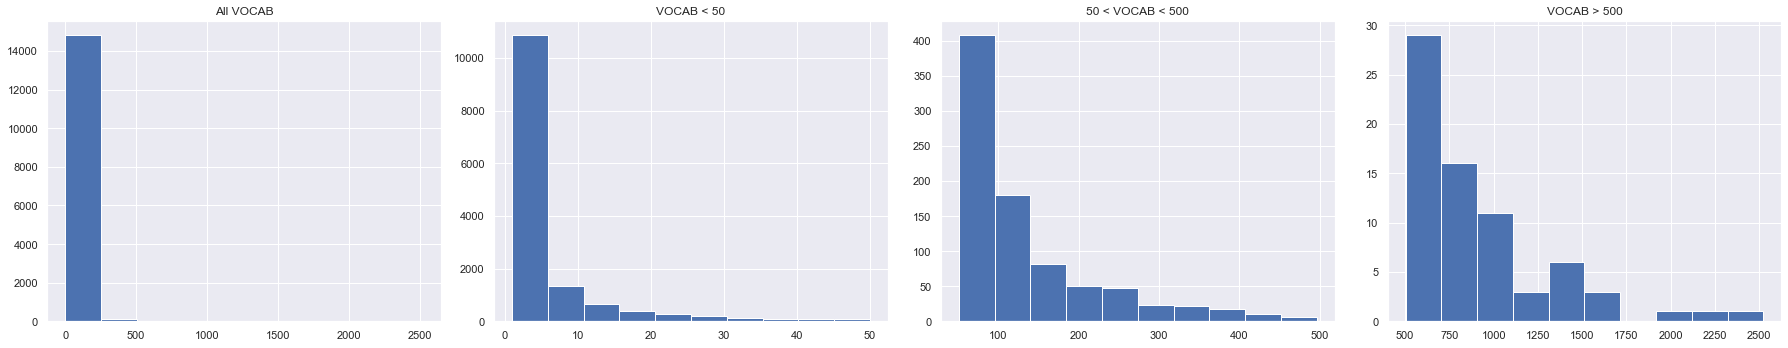

In [50]:
fig, axs = plt.subplots(1, 4, tight_layout=True, figsize = (25, 5))
axs[0].hist(VOCAB_red.n);
axs[0].set_title('All VOCAB');
axs[1].hist(VOCAB_red.n[VOCAB_red.n <= 50]);
axs[1].set_title('VOCAB < 50');
axs[2].hist(VOCAB_red.n[(VOCAB_red.n > 50) & (VOCAB_red.n <= 500)]);
axs[2].set_title('50 < VOCAB < 500');
axs[3].hist(VOCAB_red.n[VOCAB_red.n > 500]);
axs[3].set_title('VOCAB > 500');

### Top Words

In [51]:
i = 100
print('Number of top', i, 'words =', len(VOCAB_red.n[VOCAB_red.n >= i]))
i = 50
print('Number of top', i, 'words = ', len(VOCAB_red.n[VOCAB_red.n >= i]))

Number of top 100 words = 493
Number of top 50 words =  929


### Variables

In [53]:
%whos DataFrame

Variable    Type         Data/Info
----------------------------------
DOC         DataFrame                             <...>n[10341 rows x 1 columns]
LIB         DataFrame            author_last      <...>ne1877_CSPC_pg61185.txt  
TOKEN       DataFrame                             <...>[563166 rows x 4 columns]
VOCAB       DataFrame                  term_str   <...>n[16026 rows x 7 columns]
VOCAB_red   DataFrame                  term_str   <...>n[15001 rows x 4 columns]
sw          DataFrame              dummy\nterm_str<...>n\n[179 rows x 1 columns]


# Save

In [ ]:
#DOC.to_csv('DOC.csv')
#LIB.to_csv('LIB.csv')
#VOCAB.to_csv('VOCAB.csv')
#TOKEN.to_csv('TOKEN.csv')

---
---

# EXTRA

---
## Testing
---

In [475]:
# Complete: no recipes or volumes (32472, 61185)
# Complete: recipes, no volumes (34107, 10582, 29519) 
# Complete: recipes with volumnes (15464, 12519, 19077)

epub_file = epub_list[3] 
print(epub_file)
patterns[28681]

Cookbooks/Kitchiner1830_TCO_pg28681.txt


{'start_text': 0,
 'start_line': 479,
 'start_recipe': 5368,
 'end_line': 20955,
 'volume': re.compile(r'^(INTRODUCTION|RUDIMENTS OF COOKERY|COOK\’S ORACLE|HOUSEKEEPERS\’ MANUAL|APPENDIX)(\.|\;)$',
 re.UNICODE),
 'chapter': re.compile(r'(^CHAPTER\s+[IVXLCM.]+$)|(^(INTRODUCTION|CULINARY|INVITATIONS|FRIENDLY|VARIOUS|COMPRISING|OBSERVATIONS).*$)|(^(BOILING|ROASTING|FRYING|BROILING|VEGETABLES|MARKETING TABLES)(\.|\,)$)|(^.*\&C.*$)|(^(BROTHS\,|THE MAG|GRAVIES|_FISH\.).*$)',
 re.UNICODE),
 'recipe': re.compile(r'(^(DAYS\sOF|A\sLEG|MANNERS|CARVI|ACT\sFOR|TABLE\sOF).*$)|(^.*\-\(No\.\s[0-9]{1,3}(\*\,\s\_also\_\sNo)*(\*)*\.(\*)*(\s372)*\)(\.)*$)|(^FOOTNOTES\:$)|(^\_To\s(prevent|clean|make).*\.\_$)|(^\_(Buttock\s|Paste).*$)|(^(MADE\sDISHES|FISH\sSAUCES|SPIRIT|SUBSTANCES|MEAT|POULTRY|VEGETABLES|BOILING)\.(\[66\-\*\])*$)',
 re.UNICODE),
 'del_para': re.compile(r'^XXX$', re.UNICODE)}

In [513]:
author_full = ''
        
# Get info for LIB table
book_id = int(epub_file.split('_pg')[-1].split('.')[0].replace('b','1'))
author_yr = epub_file.split('/')[-1].split('_')[0].replace('[0-9]','')
author_last = author_yr[:-4]
book_year = int(author_yr[-4:])

# Import file as lines
lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
df = pd.DataFrame(lines, columns=['line_str'])
df.index.name = 'line_num'
df.line_str = df.line_str.str.strip()
df['book_id'] = str(book_id)

# Get book title and put into LIB table
book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[patterns[book_id]['start_text']].line_str, flags=re.IGNORECASE)
temp = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
if temp.find(', by') > 0:
    author_full = temp.split(', by')[1].strip() 
book_title = temp.split(', by')[0]
print("BOOK ID:   ", book_id)      
print("BOOK INFO: " + author_last+ ' ('+ str(book_year)+ ') - '+ book_title + '\n')
              
# Remove crufts
start = patterns[book_id]['start_line'] - 1
stop  = patterns[book_id]['end_line'] + 1
df = df.iloc[start:stop] 

# -- Chunking ------------------------------------------------------------------------------------------------------------------------------

# Chunk by Volume
vol_lines = df.line_str.str.match(patterns[book_id]['volume'])
if df[vol_lines].line_str.duplicated().any():            # remove duplicates
    ix = df[vol_lines].line_str.drop_duplicates().index  # ones to keep
    vol_lines[vol_lines] = False
    vol_lines[ix] = True
vol_nums = [i+1 for i in range(df.loc[vol_lines].shape[0])]
df.loc[vol_lines, 'vol_num'] = vol_nums
if vol_nums == []:                                       # if no volumes, fill with zeros
    df['vol_num'] = 0
df.vol_num = df.vol_num.ffill()
print('VOLUMES:  ', df[vol_lines].line_str.tolist())

# Chunk by Chapter (remove empty chapters later)
chap_lines = df.line_str.str.match(patterns[book_id]['chapter'])
print('CHAPTERS: ', df[chap_lines].line_str.tolist())
chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
df.loc[chap_lines, 'chap_num'] = chap_nums
if chap_nums == []:                                     # if no chapters, fill with zeros
    df['chap_num'] = 0
df.chap_num = df.chap_num.ffill()

# Chunk by Recipe
recp_lines = df.line_str.str.match(patterns[book_id]['recipe'])
print('RECIPES: ', df[recp_lines].line_str.tolist(), '\n')
recp_nums = [i+1 for i in range(df.loc[recp_lines].shape[0])]
df.loc[recp_lines, 'recp_num'] = recp_nums
if recp_nums == []:                                      # if no recipes, fill with zeros
    df['recp_num'] = 0
df.recp_num = df.recp_num.ffill()
# Recipe Correction when Intro Present (to prevent removal when Group below)
if book_id == 19077:
    df.iloc[(df[df['line_str'].str.match('Our taste')].index.values.item()-336):(patterns[book_id]['start_recipe']-336-1), 4] = 0
if book_id == 28681:
    df.iloc[(df[df['line_str'].str.match('The following receipts are not')].index.values.item()-478):(patterns[book_id]['start_recipe']-478-1), 4] = 0
    
# -- End Chunking --------------------------------------------------------------------------------------------------------------------------

# Clean up
df = df[~df.vol_num.isna()]  # Remove volume heading lines
df = df.loc[~vol_lines]      # Remove everything before volume 1
df['vol_num'] = df['vol_num'].astype('int')

df = df[~df.chap_num.isna()] # Remove chapter heading lines
df = df.loc[~chap_lines]     # Remove everything before chapter 1
df['chap_num'] = df['chap_num'].astype('int')

# Group -- Note that we exclude the book level in the OHCO at this point
df = df.groupby(OHCO[1:4]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string

# Split into paragrpahs
df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
df = df[~df['para_str'].str.match(r'^\s*$')]         # Remove empty paragraphs
para_lines = df['para_str'].str.match(patterns[book_id]['del_para'])
#print(df[para_lines])
df = df[~para_lines]                                 # Remove paragraphs matching conditions in patterns

df.index.names = OHCO[1:5]                           # MAY NOT BE NECESSARY UNTIL THE END


BOOK ID:    28681
BOOK INFO: Kitchiner (1830) - The Cook's Oracle; and Housekeeper's Manual

VOLUMES:   ['INTRODUCTION.', 'RUDIMENTS OF COOKERY.', 'COOK’S ORACLE.', 'APPENDIX;', 'HOUSEKEEPERS’ MANUAL.']
CHAPTERS:  ['INTRODUCTION.', 'CULINARY CURIOSITIES.', 'INVITATIONS TO DINNER--A recipe to make FORTY PERISTALTIC PERSUADERS.', 'INVITATIONS TO DINNER', 'FRIENDLY ADVICE TO COOKS,[46-*] AND OTHER SERVANTS', 'CHAPTER I.', 'CHAPTER II.', 'ROASTING.', 'CHAPTER III.', 'FRYING.', 'CHAPTER IV.', 'BROILING.', 'CHAPTER V.', 'VEGETABLES.', 'CHAPTER VI.', 'CHAPTER VII.', 'CHAPTER VIII.', 'GRAVIES AND SAUCES.', 'CHAPTER IX.', 'BOILING.', 'ROASTING.', 'FRYING.', 'BROILING.', 'VEGETABLES.', '_FISH._', 'BROTHS, GRAVIES, AND SOUPS.', 'GRAVIES AND SAUCES.', 'MATERIALS USED FOR FORCEMEAT, STUFFINGS, &C.', 'THE MAGAZINE OF TASTE.--(No. 462.)', 'MADE DISHES, &C.', 'MARKETING TABLES,', 'VEGETABLES.', 'COMPRISING', 'OBSERVATIONS ON PUDDINGS AND PIES.', 'OBSERVATIONS ON PICKLES.', 'VARIOUS USEFUL FAMILY RECEI

In [1744]:
df[recp_lines].line_str.unique() # 

array(['ASPARAGUS SOUP.', 'BEEF SOUP.', 'GRAVY SOUP.',
       'SOUP WITH BOUILLI.', 'VEAL SOUP.', 'OYSTER SOUP.', 'BARLEY SOUP.',
       'DRIED PEA SOUP.', 'GREEN PEA SOUP.', 'OCHRA SOUP.',
       'HARE OR RABBIT SOUP.', 'SOUP OF ANY KIND OF OLD FOWL.',
       'CATFISH SOUP.', 'ONION SOUP.', 'TO DRESS TURTLE.',
       'FOR THE SOUP.', "MOCK TURTLE SOUP OF CALF'S HEAD.",
       'DIRECTIONS FOR CURING BEEF.', 'TO DRY BEEF FOR SUMMER USE.',
       'TO CORN BEEF IN HOT WEATHER.',
       'IMPORTANT OBSERVATIONS ON ROASTING, BOILING, FRYING, &c.',
       'BEEF A-LA-MODE.', 'BRISKET OF BEEF BAKED.', 'BEEF OLIVES.',
       'TO STEW A RUMP OF BEEF.', 'A FRICANDO OF BEEF.',
       'AN EXCELLENT METHOD OF DRESSING BEEF.',
       'TO COLLAR A FLANK OF BEEF.', "TO MAKE HUNTERS' BEEF.",
       'A NICE LITTLE DISH OF BEEF.', 'BEEF STEAKS.', 'TO HASH BEEF.',
       'BEEF STEAK PIE.', 'BEEF A-LA-DAUBE.',
       'DIRECTIONS FOR THE PIECES IN THE DIFFERENT QUARTERS OF VEAL.',
       'VEAL CUTLETS FROM TH

---
## Patterns
---

book_id | front                                    | sec_num | Header 1 (Volume) | Header 2 (Chapter) | Header 3 | Header 4 (Recipe) | Header 5 (Other) | 
--------|------------------------------------------|---------|-------------------|-----------|----------|----------|----------|
61185   | `PREFACE.\n\s*-`, `CONTENTS.\n\s*-`      |`[1-3]`||`IX. —SPRING DISHES`, `XVII. —TURTLE SOUP.` |(none)|(none)|(none)|
12519   | `PREFACE`, `INTRODUCTION.`, `CONTENTS.`  |`[1-3]`||`SOUPS\n\nA`, `CORDIALS, &c.\n\nG` | (none) |`BEEF SOUP.\n`, `MUTTON.\n`|(none)|
34107   | `INDEX.`(TOC), `INTRODUCTION BY....`, `PREFACE BY....`, `PREFACE OF....`, `COPY OF....`,  | `[1]` ||(none)| `No. 1.--HOME-MADE CURRY POWDER.`, `  No. 44a.--MINT CHUTNEY.`, ` Tamil and English Names... ` | `In England.`, `In Ceylon.`, `N.B.--`, `_Mode._--` |(none)|
15464   | `FOREWORD`, `CONTENTS`                   | `[1]`   ||`SAVE WHEAT\n\n_TEXT_`, `SAVE FOOD\n\n_TEXT_` |`THE USE OF CORN\n\nCORNMEAL `, `TO RENDER\n\n TO `| `CORNMEAL ROLLS\n1`, `PLAIN PASTRY\nOne`, `WHITE SAUCE\n`| `[Illustration]` |
32472   | `CONTENTS`, `INDEX`                      |`[1,2]` ||`I/n/nA BALANCED DIET`|`THE BASAL METABOLISM OF MEN`|(none)|(note: very short, more of a paper)|
19077   | `PREFACE TO THE...`, `Contents`          |`[1-3]`| `PART I.\n\nSALADS.`, `Part III.\n\nCHAFING` |`INTRODUCTION.`, `HOW TO MAKE...`| `=The Dressing.=`, `=How to Clean Cress.=`, `=CELERY-AND-NUT SALAD.=` | `INGREDIENTS.`, `_Method._` |`[Illustration:` | 
29519   | `CONTENTS.`, `PREFACE.`                  |`[1-3]`||`SOUPS.\n\n*`, `CREAMS.\n\n*`, `INDEX.\n\n*`|(none)|`HARE SOUP.`, `LEMON CREAM.`|`[Illustration: `
10582   | (`no TOC, treat INTRO as VOL`)           |`[1-8]`||`INTRODUCTION`, `*\n\nMENU I`, `*\n\nMENU II`|(none)|`MARKET ORDERS`, `MARKET ORDER`, `RECIPES AND MENUS`, `FRUIT CUP`| `[Illustration: `
54568   | `_PREFACE_`, `CONTENTS`                  |`[1-4]`|`\n\n\nINTRODUCTION\n\nThe`    |(none)|(none)|(none)| 
        |                                          |       |`\n\n\nPART I\nEXPLANATORY LESSONS\n\nPREP`|`\n\nPREPARATION OF FOOD\n=Digest`, `\n\nTHE FIVE FOOD...\nFor`| `=Digestibility.=`, `=Albuminoids.=`|  `\s=Physical Changes.=` | 
        |                                          |       |`\n\n\nPART II\nRECIPES\n\nBEEF`|`\n\nBEEF-JUICE...\n=Beef`, `\n\n\nDRINKS\n\nEGG`, `\n\n\nDIET LISTS...\nDiet` |(none), `\n\nLIQUID DIET--\nNo`, `\n\nLIGHT DIET--\nLight`| `\n\nBEEF-JUICE\n`, `\n\nEGG-NOG\n`, `No. 1`, `FIRST DAY.` | `=Beef-Juice.=`, `=Bottled.=`, `=With Herbs.=` |        
        |                                          |       |`\n\n\nSERVING\n\nIf `, `\n\n\nTHE FEEDING OF...\n\nThere `, `\n\n\nDISTRICT NURSING\n\nIn `, `\n\n\nLITERATURE\n\nIn ` |(none), `\n\nGENERAL RULES FOR FEEDING.\n`, `\n=To Make a Fire.=`, `\n\nAPPARATUS\n` | `MONDAY`, `From the Sixth Week to the Sixth Month`, `No. 1` | `=Condensed Milk.=`, `=Mint Sauce.=` | |
28681   | `PREFACE\n TO\n`, `PREFACE`, `CONTENTS.` |`[1-5]`|`INTRODUCTION.`, `RUDIMENTS OF COOKERY.`, `APPENDIX.` | | | `[Illustration: _Fig. 12._]`| `FOOTNOTES:`
        |                                          |       |`\n\n\n\nINTRODUCTION.\n\n`| `CULINARY CURIOSITIES.` | `_Sauce for a goose, A.D. 1381._`, `“THICK SAUCE FOR A BOILED CHICKEN.--` | | |
        |                                          |       |`\n\n\n\nRUDIMENTS OF COOKERY.\n\n` | `\n\n\n\nCHAPTER I.\n BOILING.`, `\n\n\n\nCHAPTER IX.\nMADE DISHES.`| `BAKING.`| |  | |
        |                                          |       |`\n\n\n\nTHE\nCOOK'S ORACLE.\nBOILING.`(5359) | `RECEIPTS`, `\n\n\n\nMARKETING TABLES,\n\n`  | `GRAVIES AND SAUCES.`, `MADE DISHES, &C.`, `MEAT.`, `VEGETABLES.` | `_Essence of Celery._--(No. 409.)`,` CALF’S HEAD.--`, `_Minced Collops._` | | |
        |                                          |       |`\n\n\n\nAPPENDIX;\n\n` | `COMPRISING\n DIRECTIONS FOR MAKING\n ...`, `OBSERVATIONS ON PICKLES.` | `_Puff Paste._--(No. 1.)`, `_Gherkins._--(No. 117.)`

### Virginia Housewife
---

##### Virginia Housewife
* CHAPTERS
    * SOUPS
    * POULTRY, &c.
    * PUDDINGS, &c.
    * CORDIALS, &c
    * Little Dishes for a Second Course, or Supper.
    * BEEF.
    * VEAL.
    * LAMB.
    * PORK.
    * FISH.
    * CAKES.
    * MUTTON.
    * SAUCES.
    * PICKLING.
    * PRESERVES.
    * VEGETABLES.
    * ICE\sCREAMS.
    * COLD\sCREAMS.


* SOUPS
  * ASPARAGUS SOUP., BEEF SOUP., GRAVY SOUP., SOUP WITH BOUILLI., VEAL SOUP., OYSTER SOUP., BARLEY SOUP., DRIED PEA SOUP., GREEN PEA SOUP., OCHRA SOUP., HARE OR RABBIT SOUP., SOUP OF ANY KIND OF OLD FOWL.,
  * CATFISH SOUP., ONION SOUP., TO DRESS TURTLE., FOR THE SOUP., "MOCK TURTLE SOUP OF CALFS HEAD.", 
* BEEF.
  * DIRECTIONS FOR CURING BEEF., TO DRY BEEF FOR SUMMER USE., TO CORN BEEF IN HOT WEATHER., BEEF A-LA-MODE., BRISKET OF BEEF BAKED., BEEF OLIVES., TO STEW A RUMP OF BEEF., A FRICANDO OF BEEF., 
  * AN EXCELLENT METHOD OF DRESSING BEEF., TO COLLAR A FLANK OF BEEF., "TO MAKE HUNTERS BEEF.", A NICE LITTLE DISH OF BEEF., BEEF STEAKS., TO HASH BEEF., BEEF STEAK PIE., BEEF A-LA-DAUBE., 
* VEAL.
  * DIRECTIONS FOR THE PIECES IN THE DIFFERENT QUARTERS OF VEAL., VEAL CUTLETS FROM THE FILLET OR LEG., VEAL CHOPS., VEAL CUTLETS., KNUCKLE OF VEAL., BAKED FILLET OF VEAL., SCOTCH COLLOPS OF VEAL., VEAL OLIVES.,
  * RAGOUT OF A BREAST OF VEAL., FRICANDO OF VEAL., TO MAKE A PIE OF SWEETBREADS AND OYSTERS., "MOCK TURTLE OF CALFS HEAD.", "TO GRILL A CALFS HEAD.", "TO COLLAR A CALFS HEAD.", "CALFS HEART, A NICE DISH.",
  * "CALFS FEET FRICASSEE.", "TO FRY CALFS FEET.", TO PREPARE RENNET., "TO HASH A CALFS HEAD.", "TO BAKE A CALFS HEAD.", "TO STUFF AND ROAST A CALFS LIVER.", "TO BROIL CALFS LIVER.", 
* LAMB.
  * BAKED LAMB., FRIED LAMB., "TO DRESS LAMBS HEAD AND FEET.", 
* MUTTON.
  * BOILED LEG OF MUTTON., ROASTED LEG., BAKED LEG OF MUTTON., STEAKS OF A LEG OF MUTTON., TO HARRICO MUTTON., MUTTON CHOPS., BOILED BREAST OF MUTTON., BREAST OF MUTTON IN RAGOUT., TO GRILL A BREAST OF MUTTON.,
  * BOILED SHOULDER OF MUTTON., SHOULDER OF MUTTON WITH CELERY SAUCE., ROASTED LOIN OF MUTTON.,
* PORK.
  * TO CURE BACON., TO MAKE SOUSE., TO ROAST A PIG., TO ROAST A FORE-QUARTER OF SHOTE., TO MAKE SHOTE CUTLETS., TO CORN SHOTE., "SHOTES HEAD.", LEG OF PORK WITH PEASE PUDDING., STEWED CHINE.,
  * TO TOAST A HAM., TO STUFF A HAM., SOUSED FEET IN RAGOUT., TO MAKE SAUSAGES., TO MAKE BLACK PUDDINGS., A SEA PIE., TO MAKE PASTE FOR THE PIE., BOLOGNA SAUSAGES., 
* FISH.
  * TO CURE HERRINGS., TO BAKE STURGEON., TO MAKE STURGEON CUTLETS., STURGEON STEAKS., TO BOIL STURGEON., TO BAKE A SHAD., TO BOIL A SHAD., TO ROAST A SHAD., TO BROIL A SHAD., TO BOIL ROCK FISH., TO FRY PERCH.,
  * TO PICKLE OYSTERS., TO MAKE A CURRY OF CATFISH.,"TO DRESS A CODS HEAD AND SHOULDERS.", "TO MAKE SAUCE FOR THE CODS HEAD.", TO DRESS A SALT COD., MATELOTE OF ANY KIND OF FIRM FISH., CHOWDER, A SEA DISH.,
  * TO PICKLE STURGEON., TO CAVEACH FISH., TO DRESS COD FISH., COD FISH PIE., TO DRESS ANY KIND OF SALTED FISH., TO FRICASSEE COD SOUNDS AND TONGUES., AN EXCELLENT WAY TO DRESS FISH., FISH A-LA-DAUB., FISH IN JELLY., 
  * TO MAKE EGG SAUCE FOR A SALT COD., TO DRESS COD SOUNDS., TO STEW CARP., TO BOIL EELS., TO PITCHCOCK EELS., TO BROIL EELS., TO SCOLLOP OYSTERS., TO FRY OYSTERS., TO MAKE OYSTER LOAVES., 
* POULTRY, &c.
  * TO ROAST A GOOSE., TO MAKE SAUCE FOR A GOOSE., TO BOIL DUCKS WITH ONION SAUCE., TO MAKE ONION SAUCE., TO ROAST DUCKS., TO BOIL A TURKEY WITH OYSTER SAUCE., TO MAKE SAUCE FOR A TURKEY., TO ROAST A TURKEY.,
  * TO BOIL FOWLS., TO MAKE WHITE SAUCE FOR FOWLS., FRICASSEE OF SMALL CHICKENS., TO ROAST LARGE FOWLS., TO MAKE EGG SAUCE., TO BOIL YOUNG CHICKENS., TO ROAST YOUNG CHICKENS., FRIED CHICKENS., TO ROAST WOODCOCKS OR SNIPES.,
  * TO ROAST WILD DUCKS OR TEAL., TO BOIL PIGEONS., TO ROAST PIGEONS., TO ROAST PARTRIDGES OR ANY SMALL BIRDS., TO BROIL RABBITS., TO ROAST RABBITS., TO STEW WILD DUCKS., TO DRESS DUCKS WITH JUICE OF ORANGES.,
  * TO DRESS DUCKS WITH ONIONS., "TO ROAST A CALFS HEAD.", TO MAKE A DISH OF CURRY AFTER THE EAST INDIAN MANNER., DISH OF RICE TO BE SERVED UP WITH THE CURRY, IN A DISH BY ITSELF., OCHRA AND TOMATOS., GUMBO--A WEST INDIA DISH.,
  * PEPPER POT., SPANISH METHOD OF DRESSING GIBLETS., PASTE FOR MEAT DUMPLINS., TO MAKE AN OLLO--A SPANISH DISH., ROPA VEIJA--SPANISH., CHICKEN PUDDING, A FAVOURITE VIRGINIA DISH., TO MAKE POLENTA., MACARONI., MOCK MACARONI., 
  * TO MAKE CROQUETS., TO MAKE VERMECELLI., COMMON PATTIES., EGGS IN CROQUETS., OMELETTE SOUFFLE., FONDUS., "A NICE TWELVE OCLOCK LUNCHEON.", EGGS A-LA-CREME., SAUCE A-LA-CREME, FOR THE EGGS., CABBAGE A-LA-CREME., 
  * TO MAKE AN OMELETTE., OMELETTE--ANOTHER WAY., EGGS AND TOMATOS., TO FRICASSEE EGGS., 
* SAUCES.
  * FISH SAUCE, TO KEEP A YEAR., SAUCE FOR WILD FOWL., SAUCE FOR BOILED RABBITS., GRAVY., FORCEMEAT BALLS., SAUCE FOR BOILED DUCKS OR RABBITS., LOBSTER SAUCE., SHRIMP SAUCE., OYSTER SAUCE FOR FISH., CELERY SAUCE., 
  * MUSHROOM SAUCE., COMMON SAUCE., TO MELT BUTTER., CAPER SAUCE., OYSTER CATSUP., CELERY VINEGAR., 
* VEGETABLES.
  * TO DRESS SALAD., TO BOIL POTATOS., TO FRY SLICED POTATOS., POTATOS MASHED., POTATOS MASHED WITH ONIONS., TO ROAST POTATOS., TO ROAST POTATOS UNDER MEAT., POTATO BALLS., JERUSALEM ARTICHOKES., CABBAGE., SAVOYS.,
  * SPROUTS AND YOUNG GREENS., ASPARAGUS., SEA-KALE., TO SCOLLOP TOMATOS., TO STEW TOMATOS., CAULIFLOWER., RED BEET ROOTS., PARSNIPS., CARROTS., TURNIPS., TO MASH TURNIPS., TURNIP TOPS., FRENCH BEANS., ARTICHOKES.,
  * BROCOLI., PEAS., PUREE OF TURNIPS., RAGOUT OF TURNIPS., RAGOUT OF FRENCH BEANS, SNAPS, STRING BEANS., MAZAGAN BEANS., LIMA, OR SUGAR BEANS., TURNIP ROOTED CABBAGE., EGG PLANT., POTATO PUMPKIN., SWEET POTATO., 
  * SWEET POTATOS STEWED., SWEET POTATOS BROILED., SPINACH., SORREL., CABBAGE PUDDING., SQUASH OR CIMLIN., WINTER SQUASH., FIELD PEAS., CABBAGE WITH ONIONS., SALSIFY., STEWED SALSIFY., STEWED MUSHROOMS., BROILED MUSHROOMS.,
  * TO BOIL RICE., RICE JOURNEY, OR JOHNNY CAKE.,
* PUDDINGS, &c.
  * OBSERVATIONS ON PUDDINGS AND CAKES., RICE MILK FOR A DESSERT., TO MAKE PUFF PASTE., TO MAKE MINCEMEAT FOR PIES., TO MAKE JELLY FROM FEET., A SWEETMEAT PUDDING., TO MAKE AN ORANGE PUDDING., AN APPLE CUSTARD., BOILED LOAF.,
  * TRANSPARENT PUDDING., FLUMMERY., BURNT CUSTARD., AN ENGLISH PLUM PUDDING., MARROW PUDDING., SIPPET PUDDING., SWEET POTATO PUDDING., AN ARROW ROOT PUDDING., SAGO PUDDING., PUFF PUDDING., RICE PUDDING., PLUM PUDDING.,
  * ALMOND PUDDING., QUIRE OF PAPER PANCAKES., A CURD PUDDING., LEMON PUDDING., BREAD PUDDING., THE HENRIETTA PUDDING., TANSEY PUDDING., CHERRY PUDDING., APPLE PIE., BAKED APPLE PUDDING., A NICE BOILED PUDDING.,
  * AN EXCELLENT AND CHEAP DESSERT DISH., SLICED APPLE PUDDING., BAKED INDIAN MEAL PUDDING., BOILED INDIAN MEAL PUDDING., PUMPKIN PUDDING., FAYETTE PUDDING., MACCARONI PUDDING., POTATO PASTE., COMPOTE OF APPLES., CHARLOTTE.,
  * APPLE FRITTERS., BELL FRITTERS., BREAD FRITTERS., SPANISH FRITTERS., TO MAKE MUSH., 
* CAKES.
  * JUMBALS., MACAROONE., TO MAKE DROP BISCUIT., TAVERN BISCUIT., RUSK., GINGER BREAD., PLEBEIAN GINGER BREAD., SUGAR GINGER BREAD., DOUGH NUTS--A YANKEE CAKE., RISEN CAKE., POUND CAKE., SAVOY OR SPUNGE CAKE., 
  * A RICH FRUIT CAKE., NAPLES BISCUIT., SHREWSBURY CAKES., LITTLE PLUM CAKES., SODA CAKES., TO MAKE BREAD., TO MAKE NICE BISCUIT., RICE BREAD., MIXED BREAD., PATENT YEAST., TO PREPARE THE CAKES., 
  * ANOTHER METHOD FOR MAKING YEAST., NICE BUNS., MUFFINS., FRENCH ROLLS., CRUMPETS., APOQUINIMINC CAKES., BATTER CAKES., BATTER BREAD., CREAM CAKES., SOUFLE BISCUITS., CORN MEAL BREAD., SWEET POTATO BUNS., RICE WOFFLES., 
  * VELVET CAKES., CHOCOLATE CAKES., WAFERS., BUCKWHEAT CAKES., OBSERVATIONS ON ICE CREAMS., 
* ICE CREAMS.
  * VANILLA CREAM., RASPBERRY CREAM., COCOA NUT CREAM., CHOCOLATE CREAM., OYSTER CREAM., ICED JELLY., PEACH CREAM., COFFEE CREAM., QUINCE CREAM., CITRON CREAM., ALMOND CREAM., LEMON CREAM., LEMONADE ICED., TO MAKE CUSTARD.,
  * TO MAKE A TRIFLE., RICE BLANC MANGE., FLOATING ISLAND., SYLLABUB.,
* COLD CREAMS.
  * ORANGE CREAM., TEA CREAM., SAGO CREAM., BARLEY CREAM., GOOSEBERRY FOOL., TO MAKE SLIP., CURDS AND CREAM., BLANC MANGE., "TO MAKE A HENS NEST.",
* Little Dishes for a Second Course, or Supper.
  * PHEASANTS A-LA-DAUB., PARTRIDGES A-LA-DAUB., CHICKENS A-LA-DAUB., TO MAKE SAVOURY JELLY., TURKEY A-LA-DAUB., SALMAGUNDI., AN EXCELLENT RELISH AFTER DINNER., TO STEW PERCH.,
* PRESERVES.
  * DIRECTIONS FOR MAKING PRESERVES., TO PRESERVE CLING-STONE PEACHES., CLING-STONES SLICED., SOFT PEACHES., PEACH MARMALADE., PEACH CHIPS., PEARS., PEAR MARMALADE., QUINCES., CURRANT JELLY., QUINCE JELLY., QUINCE MARMALADE., 
  * CHERRIES., MORELLO CHERRIES., TO DRY CHERRIES., RASPBERRY JAM., TO PRESERVE STRAWBERRIES., STRAWBERRY JAM., GOOSEBERRIES., APRICOTS IN BRANDY., PEACHES IN BRANDY., CHERRIES IN BRANDY., MAGNUM BONUM PLUMS IN BRANDY., 
* PICKLING.
  * LEMON PICKLE., TOMATO CATSUP., TOMATO MARMALADE., TOMATO SWEET MARMALADE., TOMATO SOY., PEPPER VINEGAR., MUSHROOM CATSUP., TARRAGON OR ASTRAGON VINEGAR., CURRY POWDER., TO PICKLE CUCUMBERS., OIL MANGOS.,
  * TO MAKE THE STUFFING FOR FORTY MELONS., TO MAKE YELLOW PICKLE., TO MAKE GREEN PICKLES., TO PREPARE VINEGAR FOR GREEN OR YELLOW PICKLE., TO PICKLE ONIONS., TO PICKLE NASTERTIUMS., TO PICKLE RADISH PODS., 
  * TO PICKLE ENGLISH WALNUTS., TO PICKLE PEPPERS., TO MAKE WALNUT CATSUP., TO PICKLE GREEN NECTARINES OR APRICOTS., TO PICKLE ASPARAGUS., OBSERVATIONS ON PICKLING., 
* CORDIALS, &c.
  * GINGER WINE., ORGEAT., CHERRY SHRUB., CURRANT WINE., TO MAKE CHERRY BRANDY., ROSE BRANDY., PEACH CORDIAL., RASPBERRY CORDIAL., RASPBERRY VINEGAR., MINT CORDIAL., HYDROMEL, OR MEAD., TO MAKE A SUBSTITUTE FOR ARRACK., 
  * LEMON CORDIAL., GINGER BEER., SPRUCE BEER., MOLASSES BEER., TO KEEP LEMON-JUICE., SUGAR VINEGAR., HONEY VINEGAR., SYRUP OF VINEGAR., AROMATIC VINEGAR., VINEGAR OF THE FOUR THIEVES., LAVENDER WATER., HUNGARIAN WATER.,
  * TO PREPARE COSMETIC SOAP FOR WASHING THE HANDS., COLOGNE WATER., SOFT POMATUM., TO MAKE SOAP., TO MAKE STARCH., TO DRY HERBS., TO CLEAN SILVER UTENSILS., TO MAKE BLACKING., TO CLEAN KNIVES AND FORKS.

### Kitchiner
---

#### Kitchiner

* **INTRODUCTION**
   * CULINARY CURIOSITIES 
        * DAYS OF YORE
        * A LEG OF MUTTON
        * FOOTNOTES:        
   * INVITATIONS TO DINNER
        * MANNERS MAKE THE MAN
        * CARVING
        * FOOTNOTES:        
   * FRIENDLY ADVICE TO COOKS,[46-*] AND OTHER SERVANTS
        * ACT FOR, AND SPEAK OF, EVERY BODY AS IF THEY WERE PRESENT
        * FOOTNOTES:        
        * TABLE OF WEIGHTS AND MEASURES
        * FOOTNOTES:        
* **RUDIMENTS OF COOKERY**
    * CHAPTER I
        * BOILING[66-*]
        * BAKING 
        * FOOTNOTES:        
    * CHAPTER II
        * ROASTING
        * DREDGINGS
        * BASTINGS 
        * FOOTNOTES:        
    * CHAPTER III
        * FRYING
        * FOOTNOTES:        
    * CHAPTER IV
        * BROILING
        * FOOTNOTES:       
    * CHAPTER V
        * VEGETABLES
        * FOOTNOTES:       
    * CHAPTER VI
        * FISH
        * FISH SAUCES
        * FOOTNOTES:       
    * CHAPTER VII
        * BROTHS AND SOUPS
        * BROTH HERBS, SOUP ROOTS, AND SEASONINGS
        * FOOTNOTES:        
    * CHAPTER VIII
        * GRAVIES AND SAUCES
        * FOOTNOTES:     
    * CHAPTER IX
        * MADE DISHES. 
        * FOOTNOTES:
* **THE \n COOK’S ORACLE**
    * BOILING
        * _Leg of Mutton._--(No. 1.)
        * _Ham_,--(No. 14.)
        * _Tripe._--(No. 18.)
        * _Cow-Heel_,--(No. 18.*)
        * FOOTNOTES:             
    * ROASTING
        * _Sirloin of Beef._--(No. 19.)
        * _VEAL._--(No. 33.)   
        * _Lobster._--(No. 82.)
        * FOOTNOTES:        
    * FRYING    
        * _To clarify Drippings._--(No. 83.)
        * _Pork Chops._--(No. 93.)
        * FOOTNOTES:
    * BROILING
        * _Chops or Steaks._[151-*]--(No. 94.)
        * _Pigeons_,--(No. 98.)
        * FOOTNOTES:        
    * VEGETABLES.
        * _Sixteen Ways of dressing Potatoes._[155-*]--(No. 102.)
        * _Salads._--(No. 138*, _also_ No. 372).
        * FOOTNOTES:        
    * _FISH._
        * _Turbot to boil._--(No. 140).
        * _Oysters fried._[192-*]--(No. 183.)
        * FOOTNOTES:        
    * BROTHS, GRAVIES, AND SOUPS.
        * _Beef Broth._[193-*]--(No. 185.)
        * _FISH SOUPS._--(No. 225.)
        * _Portable[223-+] Soup, or Glaze._--(No. 252.)
        * _To clarify Broth or Gravy._--(No. 252*.)
        * FOOTNOTES:
            * WINTER SOUP.--(No. 227.)
    * GRAVIES AND SAUCES.
        * _Melted Butter,_
        * _Melted Butter._
        * _Thickening._--(No. 257.)
        * _Forcemeat Stuffings._--(No. 373.)   
    * MATERIALS USED FOR FORCEMEAT, STUFFINGS, &C
        * SPIRIT.
        * SUBSTANCES.
        * _Stuffing for Veal, roast Turkey, Fowl, &c._--(No. 374.)
        * _To Dry sweet and savoury Herbs._--(No. 461.)
    * THE MAGAZINE OF TASTE.--(No. 462.)
        * _Toast and Water._--(No. 463.)
        * _Calves’-Feet Jelly._--(No. 481.)
        * FOOTNOTES:        
    * MADE DISHES, &C. 
        * _Receipts for economical_ Made Dishes,_ written for the_ Cook’s Oracle, \n _by an accomplished_ English Lady.--(No. 483.)
        * _To hash Mutton, &c._--(No. 484.)
        * MRS. PHILLIPS’S _Irish Stew._--(No. 488.)
        * _Sandwiches_,--(No. 504.)
        * MR. GAY’S _Receipt to stew a Knuckle of Veal._--(No. 524.)
        * No. 560
            * _Boston Apple Pudding._
            * _Boiled Custards._  
            * _Spring Fruit Soup._
            * _Another Way._
        * _To make Beef, Mutton, or Veal Tea._--(No. 563.)  
        * _Deviled Biscuit_,--(No. 574.)
        * FOOTNOTES:        
    * MARKETING TABLES,
        * MEAT.
        * POULTRY.
        * VEGETABLES.      
* **APPENDIX;**
    * COMPRISING \n DIRECTIONS FOR MAKING \n PASTRY, PRESERVES, BREAD, PUDDINGS, PICKLES, &c. &c.
        * _Puff Paste._--(No. 1.)
        * _Yorkshire Cakes._--(No. 104.)
        * FOOTNOTES:
    * OBSERVATIONS ON PUDDINGS AND PIES.
        * _College Puddings._--(No. 105.)
        * _Cottage Potato Pudding or Cake._--(No. 115.)
        * FOOTNOTES:
    * OBSERVATIONS ON PICKLES.
        * _Walnuts._--(No. 116.)
        * _Indian or mixed Pickles--Mango or Piccalilli._--(No. 123.)
* **HOUSEKEEPERS’ MANUAL**
   * VARIOUS USEFUL FAMILY RECEIPTS
        * _To prevent Beer becoming Flat after it is drawn._
        * _To clean Plate._
        * _To make_ WOODEN _Stairs have the appearance of_ STONE.
        * _Paste._
   * OBSERVATIONS ON CARVING
        * [Illustration: _Fig. 1._]
        * [Illustration: _Fig. 12._]
        * _Buttock of Beef_
        * FOOTNOTES:

### Nelsons
---

#### Nelsons Home Comforts


**Volumes**  
(none)  

**Chapters**  
  SOUPS  
  LITTLE DISHES OF FISH  
  LITTLE DISHES OF MEAT  
  PUDDINGS  
  JELLIES (ON JELLY-MAKING)  
  CREAMS  
  CAKES  
  BEVERAGES  
  MACARONI, ETC.  
  HINTS ON HOUSEKEEPING  
  
**Recipes**  
* SOUPS.  
  * BEEF AND ONION SOUP., "NELSONS MULLIGATAWNY SOUP.", LENTIL, AND VEGETABLE SOUP., BEEF, PEA, AND VEGETABLE SOUP., BROWN RABBIT SOUP CLEAR., HARE SOUP., MULLIGATAWNY SOUP., THIN MULLIGATAWNY SOUP., BROWN ARTICHOKE SOUP., TURTLE SOUP., MOCK TURTLE SOUP., CLEAR VERMICELLI SOUP.
  * SOUP JULIENNE.,
  * BEEF,  BEEF TEA AS A SOLID., GRAVY., GLAZE.  
* LITTLE DISHES OF FISH.
  * FRIED SOLE., FRIED HERRINGS., 
  * FILLETED SOLES., FILLETS OF SOLE SAUTÉS., FILLETS OF SOLE FRIED., FILLETS OF SOLE WITH LOBSTER., FILLETS OF SOLE EN ASPIC., 
  * BAKED WHITING., COD CUTLETS., ROLLED HERRINGS., GALANTINE OF FISH., COLLARED EELS.
* LITTLE DISHES OF MEAT.
  * MUTTON CUTLETS., ROULADES OF MUTTON., MUTTON COLLOPS., MUTTON SAUTÉ., COLD MUTTON POTTED., MUTTON PIES.
  * CHICKEN IN ASPIC JELLY., BROWN FRICASSÉE OF CHICKEN., CHICKEN SAUTÉ.
  * VEAL CUTLETS IN WHITE SAUCE., VEAL À LA CASSEROLE., VEAL AND HAM PIE.
  * KIDNEYS SAUTÉS., TINNED KIDNEYS WITH MUSHROOMS., KIDNEYS WITH PICCALILLI SAUCE., BROILED KIDNEYS.
  * OX BRAIN., BRAIN FRITTERS.
  * "LAMBS FRY.", "LAMBS SWEETBREADS."  
  * RAISED PORK PIE.,  PORK SAUSAGES.
  * MARROW TOAST., POTATO HASH., DRY CURRY., CROQUETTES., "MEAT CAKES À LITALIENNE."
* PUDDINGS.
  * CUSTARD PUDDING., SOUFFLÉ PUDDING., CABINET PUDDING., WARWICKSHIRE PUDDING., VANILLA RUSK PUDDING., JUBILEE PUDDING., NATAL PUDDING., "QUEENS PUDDING.", CHOCOLATE PUDDING., COCOA-NUT PUDDING., RASPBERRY AND CURRANT PUDDING., THE CAPITAL PUDDING., "DUCHESS OF FIFES PUDDING."
  * OMELET SOUFFLÉ., SPONGE SOUFFLÉ.
  * COMPOTE OF APPLES WITH FRIED BREAD., APPLE FOOL., APPLE MERINGUE.
  * BRANDY SAUCE., ITALIAN FRITTERS.,  WELSH CHEESECAKE., "FRIARS OMELET.", COMPOTE OF PRUNES., STEWED PEARS WITH RICE.
* ON JELLY-MAKING.
  * HOW TO USE GELATINE., HOW TO MAKE A JELLY-BAG.
  * RIBBON JELLY., CLARET JELLY., COFFEE JELLY., COCOA JELLY., ORANGES FILLED WITH JELLY., ORANGE FRUIT JELLY., APPLE JELLY., STRENGTHENING JELLY., ASPIC JELLY., TO MAKE A QUART OF BRILLIANT JELLY., AN ECONOMICAL JELLY., JELLY WITH FRUIT.
  * LEMON SPONGE., DUTCH FLUMMERY.
* CREAMS.
  * LEMON CREAM., STRAWBERRY CREAM., ORANGE CREAM., IMITATION LEMON CREAM., APRICOT CREAM., PINEAPPLE CREAM., PALACE CREAM., FRUIT CREAM., MANDARIN CREAM., CHERRY CREAM., VELVET CREAM., ITALIAN CREAM., CHEESE AND MACARONI CREAM., COFFEE CREAM., CHOCOLATE CREAM., FIG CREAM., CHAMPAGNE CREAM., WHIPPED CREAM.  
  * CHARTREUSE OF ORANGES., ORANGE MOUSSE.
  * BLANC-MANGE., SOLID SYLLABUB., CHARLOTTE RUSSE., BADEN-BADEN PUDDING., STRAWBERRY TRIFLE.
* CAKES.
  * POUND CAKE., PLAIN POUND CAKE., SAVOY SPONGE CAKE., COCOA-NUT CAKES., CHOCOLATE CAKES.
  * LEMON SAVOY SPONGE., MACAROONS., COCOA-NUT ROCK., SUGAR ICING., ALMOND PASTE.
* BEVERAGES.
  * GINGERADE., AN EXTRACT OF GINGER FOR FAMILY USE.,
  * LEMONADE., LEMON SYRUP., ESSENCE OF LEMON.
  * MULLED PORT WINE., MILK BEVERAGE., CITRIC ACID.
* MACARONI, ETC.
  * MACARONI WITH CHEESE., MACARONI CHEESE., MACARONI WITH BACON., MACARONI WITH ONIONS., STEWED MACARONI., MACARONI WITH TOMATOES., SWEET MACARONI.
  * LES CANAPÉS AU PARMESAN., RICE WITH PARMESAN CHEESE.  
  * BOILED CHEESE., SCALLOPED EGGS., SCOTCH WOODCOCK., MUSHROOMS WITH CREAM SAUCE., TO MINCE VEGETABLES.

### Boland - Invalid (54568)
---

#### Boland1893_Invalid_pg54568.txt

**Volumes**  
* INTRODUCTION  
* PART I  EXPLANATORY LESSONS  
* PART II  RECIPES  

**PART I Chapters**  
* PREPARATION OF FOOD  
* CHEMICAL AND PHYSICAL CHANGES  
* ELEMENTS  
* AIR  
* FIRE  
* COMPOSITION OF THE BODY  
* PRINCIPAL CHEMICAL COMPOUNDS IN THE BODY  
* THE FIVE FOOD PRINCIPLES  
  * WATER, PROTEIN, FATS, THE CARBOHYDRATES
* MILK  
* DIGESTION    
* NUTRITION  

**PART II Chapters**  
* BEEF-JUICE, BEEF-TEA, AND BROTHS
* GRUELS
* MUSH AND PORRIDGE
* DRINKS
* JELLIES
* TOAST
* SOUPS
* OYSTERS
* EGGS
* POTATOES
* MEATS
* STEWS
* SWEETBREADS
* FISH
* CUSTARDS, CREAMS, PUDDINGS, AND BLANC-MANGE
* SALADS
* ICE-CREAM, SHERBETS, AND ICES
* COOKED FRUITS
* BREAD
* CAKE
* DIET LISTS OR MENUS FOR THE SICK
* SERVING
* THE FEEDING OF CHILDREN
* DISTRICT NURSING
* LITERATURE
* CHARTS
* APPARATUS

BEEF-JUICE, BEEF-TEA, BEEF BROTH, BROTH MADE FROM BEEFSTEAK, SCOTCH BEEF BROTH, CHICKEN BROTH, MUTTON BROTH, CLAM BROTH  
BARLEY GRUEL, ARROWROOT GRUEL, OATMEAL GRUEL FROM POUNDED GRAIN, FLOUR GRUEL, CRACKER GRUEL, FARINA GRUEL, IMPERIAL GRANUM, RACAHOUT DES ARABES, INDIAN-MEAL GRUEL  
OATMEAL MUSH, FARINA, WHEAT GERM, GRANULA, CRACKED OR ROLLED WHEAT, INDIAN-MEAL MUSH, HOMINY MUSH
EGG-NOG, MILK-PUNCH, WINE WHEY, WINE WHEY WITH RENNET, LEMONADE, MILK LEMONADE, BRANDY-MILK WITH EGG, SHERRY AND EGG, STERILIZED MILK, MILK AND SELTZER, MILK AND SDA-WATER, TOAST-WATER, BARLEY-WATER, RICE-WATER, COFFEE SYRUP,
VANILLA SYRUP, OTHER SYRUPS, GRAPE JUICE, FLAXSEED TEA WITH LEMON, APPLE TEA, KUMISS, THE COCOA-BEAN, COCOA, COCOA-SHELLS, COCOA-NIBS, CHOCOLATE, TEA, COMPOSITION OF TEA, COFFEE, MULLED WINE, COCOA CORDIAL
LEMON JELLY, ORANGE JELLY, COFFEE JELLY, FRENCH JELLY WITH FRESH FRUITS, RESTORATIVE JELLY, CHICKEN JELLY, PUNCHEON JELLY
BUTTERED WATER TOAST, MILK TOAST, CREAM TOAST, FRENCH OR EGG TOAST, CROUTONS, SIPPETS, VERMICELLI TOAST
OYSTER SOUP, CHICKEN SOUP, MOCK-BISQUE SOUP, POTATO SOUP, CREAM-OF-CELERY SOUP, CREAM-OF-RICE SOUP, "QUEEN VICTORIAS FAVORITE SOUP", CHICKEN-TAPIOCA SOUP, BEEF-TAPIOCA SOUP, CHICKEN PANADA, CONSOMMÉ, BOUILLON, APPLE SOUP
RAW OYSTERS, OYSTERS ROASTED IN THE SHELL, OYSTER STEW, CREAMED OYSTERS, BROILED OYSTERS, FANCY ROAST OR PAN-BROILED OYSTERS, OYSTER BROTH, OYSTERS COOKED IN A CHAFING-DISH
SOFT-COOKED EGGS, POACHED OR DROPPED EGGS, OMELETS, CREAMY OMELET, FOAMY OMELET, OMELET WITH JELLY, OMELET WITH CHICKEN, OMELET WITH TOMATO, OMELET WITH PARSLEY, SPANISH OMELET, ORANGE OMELET
BOILED POTATOES, MASHED POTATOES, BAKED POTATOES, ROASTED POTATOES, CREAMED POTATOES, DUCHESS POTATOES
BEEF, VALUE OF BEEF, TENDERLOIN STEAK, "BEEFSTEAK À LA MAÎTRE DHÔTEL", CHICKEN, BIRDS, SQUABS, PARTRIDGE, SNIPE, PHEASANTS, WOODCOCK, REED-BIRDS, GROUSE, FIELD-LARKS, VENISON, MUTTON, DIGESTIBILITY OF MUTTON, MUTTON CHOPS
CHOPS, PAN-BROILED, FRENCH CHOPS, CHOPS IN PAPER, LAMB CHOPS
CHICKEN STEW, BEEF STEW, MUTTON STEW
CREAMED SWEETBREADS, FRICASSEED SWEETBREADS, SWEETBREADS WITH PEAS
WHEN IN SEASON, BROILED FISH, CREAMED FISH, BOILED FISH,
SOFT CUSTARD, BAKED CUSTARD, FRENCH CUSTARD, RENNET CUSTARD OR SLIP, EGG CREAM, VELVET CREAM, COFFEE CREAM, CHOCOLATE CREAM, TAPIOCA CREAM, RICE CREAM, PEACH FOAM, SNOW PUDDING, PRINCESS PUDDING, CORN-STARCH PUDDING,
BARLEY PUDDING, CREAM-OF-RICE PUDDING, FRUIT TAPIOCA, TAPIOCA JELLY, ORANGE LAYERS, ORANGE BASKETS, IRISH MOSS BLANC-MANGE, PINK BLANC-MANGE
FRENCH DRESSING, MAYONNAISE DRESSING, LETTUCE SALAD, TOMATO SALAD, CHICKEN SALAD, POTATO SALAD, POTATO SALAD WITH OLIVES, CELERY SALAD
PHILADELPHIA ICE-CREAM, ROYAL ICE-CREAM, ICE-CREAM WITH AN IMPROVISED FREEZER, FROZEN CUSTARD, LEMON SHERBET WITH GELATINE, LEMON SHERBET WITH SUGAR SYRUP, ORANGE SHERBET, APRICOT ICE
BAKED TART APPLES, BAKED SWEET APPLES, STEWED APPLES, APPLE COMPOTE, STEWED PRUNES, CRANBERRY SAUCE AND JELLY, GRAPE SAUCE, GRAPE JELLY, APPLE JELLY
LIQUID YEAST, WATER BREAD, MILK BREAD, STICKS, RUSK, DRIED RUSK, GRAHAM BREAD, CREAM-OF-TARTAR BISCUIT, SNOW-CAKES, GRAHAM GEMS, OATMEAL MUFFINS, GLUTEN BREAD, BAKING-POWDER
THE PROCESS OF CAKE MAKING, "INVALIDS SPONGE CAKE", FEATHER CAKE, LAYER CAKE, CARMINE FOR COLORING, WHITE CAKE, DREAM CAKE, CAKE FILLING AND FROSTING, WHITE MOUNTAIN FROSTING, CARAMEL FILLING, CHOCOLATE ICING, CREAM FILLING
LIQUID DIET, LIGHT DIET, "CONVALESCENTS DIET", SPRING, SUMMER, AUTUMN, WINTER
BILLS OF FARE, MAY, SEPTEMBER, JANUARY, SATURDAY, SUNDAY, MONDAY, TUESDAY
CHEMICAL COMPOSITION OF AN EGG, "COMPOSITION OF COWS MILK", COMPOSITION OF COCOA, COMPOSITION OF BREAD, COMPOSITION OF POTATO
CHINA FOR SERVING, COMMON KITCHEN CHINA, GRANITE-WARE, IRON AND TIN WARE, WOODEN WARE, LINEN, MISCELLANEOUS, FURNITURE

**PART II Recipes**  
BEEF-JUICE, BEEF-TEA, AND BROTHS  
    BEEF-JUICE, BEEF-TEA, BEEF BROTH, BROTH MADE FROM BEEFSTEAK, SCOTCH BEEF BROTH, CHICKEN BROTH, MUTTON BROTH, CLAM BROTH  
GRUELS  
    BARLEY GRUEL, ARROWROOT GRUEL, OATMEAL GRUEL FROM POUNDED GRAIN, FLOUR GRUEL, CRACKER GRUEL, FARINA GRUEL, IMPERIAL GRANUM, RACAHOUT DES ARABES, INDIAN-MEAL GRUEL  
MUSH AND PORRIDGE
    OATMEAL MUSH, FARINA, WHEAT GERM, GRANULA, CRACKED OR ROLLED WHEAT, INDIAN-MEAL MUSH, HOMINY MUSH
DRINKS
    EGG-NOG, MILK-PUNCH, WINE WHEY, WINE WHEY WITH RENNET, LEMONADE, MILK LEMONADE, BRANDY-MILK WITH EGG, SHERRY AND EGG, STERILIZED MILK, MILK AND SELTZER, MILK AND SODA-WATER, TOAST-WATER, BARLEY-WATER, RICE-WATER, COFFEE SYRUP,
    VANILLA SYRUP, OTHER SYRUPS, GRAPE JUICE, FLAXSEED TEA WITH LEMON, APPLE TEA, KUMISS, THE COCOA-BEAN, COCOA, COCOA-SHELLS, COCOA-NIBS, CHOCOLATE, TEA, COMPOSITION OF TEA, COFFEE, MULLED WINE, COCOA CORDIAL
JELLIES
    LEMON JELLY, ORANGE JELLY, COFFEE JELLY, FRENCH JELLY WITH FRESH FRUITS, RESTORATIVE JELLY, CHICKEN JELLY, PUNCHEON JELLY
TOAST
    BUTTERED WATER TOAST, MILK TOAST, CREAM TOAST, FRENCH OR EGG TOAST, CROUTONS, SIPPETS, VERMICELLI TOAST
SOUPS
    OYSTER SOUP, CHICKEN SOUP, MOCK-BISQUE SOUP, POTATO SOUP, CREAM-OF-CELERY SOUP, CREAM-OF-RICE SOUP, "QUEEN VICTORIAS FAVORITE SOUP", CHICKEN-TAPIOCA SOUP, BEEF-TAPIOCA SOUP, CHICKEN PANADA, CONSOMMÉ, BOUILLON, APPLE SOUP
OYSTERS
    RAW OYSTERS, OYSTERS ROASTED IN THE SHELL, OYSTER STEW, CREAMED OYSTERS, BROILED OYSTERS, FANCY ROAST OR PAN-BROILED OYSTERS, OYSTER BROTH, OYSTERS COOKED IN A CHAFING-DISH
EGGS
    SOFT-COOKED EGGS, POACHED OR DROPPED EGGS, OMELETS, CREAMY OMELET, FOAMY OMELET, OMELET WITH JELLY, OMELET WITH CHICKEN, OMELET WITH TOMATO, OMELET WITH PARSLEY, SPANISH OMELET, ORANGE OMELET
POTATOES
    BOILED POTATOES, MASHED POTATOES, BAKED POTATOES, ROASTED POTATOES, CREAMED POTATOES, DUCHESS POTATOES
MEATS
    BEEF, VALUE OF BEEF, TENDERLOIN STEAK, "BEEFSTEAK À LA MAÎTRE DHÔTEL", CHICKEN, BIRDS, SQUABS, PARTRIDGE, SNIPE, PHEASANTS, WOODCOCK, REED-BIRDS, GROUSE, FIELD-LARKS, VENISON, MUTTON, DIGESTIBILITY OF MUTTON, MUTTON CHOPS
    CHOPS, PAN-BROILED, FRENCH CHOPS, CHOPS IN PAPER, LAMB CHOPS
STEWS
    CHICKEN STEW, BEEF STEW, MUTTON STEW
SWEETBREADS
    CREAMED SWEETBREADS, FRICASSEED SWEETBREADS, SWEETBREADS WITH PEAS
FISH
    WHEN IN SEASON, BROILED FISH, CREAMED FISH, BOILED FISH,
CUSTARDS, CREAMS, PUDDINGS, AND BLANC-MANGE
    SOFT CUSTARD, BAKED CUSTARD, FRENCH CUSTARD, RENNET CUSTARD OR SLIP, EGG CREAM, VELVET CREAM, COFFEE CREAM, CHOCOLATE CREAM, TAPIOCA CREAM, RICE CREAM, PEACH FOAM, SNOW PUDDING, PRINCESS PUDDING, CORN-STARCH PUDDING,
    BARLEY PUDDING, CREAM-OF-RICE PUDDING, FRUIT TAPIOCA, TAPIOCA JELLY, ORANGE LAYERS, ORANGE BASKETS, IRISH MOSS BLANC-MANGE, PINK BLANC-MANGE
SALADS
    FRENCH DRESSING, MAYONNAISE DRESSING, LETTUCE SALAD, TOMATO SALAD, CHICKEN SALAD, POTATO SALAD, POTATO SALAD WITH OLIVES, CELERY SALAD
ICE-CREAM, SHERBETS, AND ICES
    PHILADELPHIA ICE-CREAM, ROYAL ICE-CREAM, ICE-CREAM WITH AN IMPROVISED FREEZER, FROZEN CUSTARD, LEMON SHERBET WITH GELATINE, LEMON SHERBET WITH SUGAR SYRUP, ORANGE SHERBET, APRICOT ICE
COOKED FRUITS
    BAKED TART APPLES, BAKED SWEET APPLES, STEWED APPLES, APPLE COMPOTE, STEWED PRUNES, CRANBERRY SAUCE AND JELLY, GRAPE SAUCE, GRAPE JELLY, APPLE JELLY
BREAD
    LIQUID YEAST, WATER BREAD, MILK BREAD, STICKS, RUSK, DRIED RUSK, GRAHAM BREAD, CREAM-OF-TARTAR BISCUIT, SNOW-CAKES, GRAHAM GEMS, OATMEAL MUFFINS, GLUTEN BREAD, BAKING-POWDER
CAKE
    THE PROCESS OF CAKE MAKING, "INVALIDS SPONGE CAKE", FEATHER CAKE, LAYER CAKE, CARMINE FOR COLORING, WHITE CAKE, DREAM CAKE, CAKE FILLING AND FROSTING, WHITE MOUNTAIN FROSTING, CARAMEL FILLING, CHOCOLATE ICING, CREAM FILLING
DIET LISTS OR MENUS FOR THE SICK
    LIQUID DIET, LIGHT DIET, "CONVALESCENTS DIET", SPRING, SUMMER, AUTUMN, WINTER
SERVING
THE FEEDING OF CHILDREN
DISTRICT NURSING
    BILLS OF FARE, MAY, SEPTEMBER, JANUARY, SATURDAY, SUNDAY, MONDAY, TUESDAY
LITERATURE
CHARTS
    CHEMICAL COMPOSITION OF AN EGG, "COMPOSITION OF COWS MILK", COMPOSITION OF COCOA, COMPOSITION OF BREAD, COMPOSITION OF POTATO
APPARATUS
    CHINA FOR SERVING, COMMON KITCHEN CHINA, GRANITE-WARE, IRON AND TIN WARE, WOODEN WARE, LINEN, MISCELLANEOUS, FURNITURE